<a href="https://colab.research.google.com/github/sokharsamb/AIMS2019-Dakar-BigDataCourse/blob/master/Beta_VAE_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
#from django.views.generic import View


In [0]:
# Convert vector to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [6]:
bs = 1000

transform = transforms.Compose([transforms.ToTensor()])

traindataset = FashionMNIST('./data', download=True, train=True, transform=transform)
testdataset = FashionMNIST('./data', download=True, train=False, transform=transform)

# Loaders
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=bs, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=bs, shuffle=False, num_workers=4)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [0]:
# Displaying routine
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [0]:
def get_shape(h,p=0,k=3,s=1):
    '''
    h: height or width of the input image
    p: paddign . 0 means no padding
    k: kernel size
    s: stride to shift kernels 
    
    --------------------
    return : size of image after applying either maxpooling or convolution
    
    '''
    return ((h+(2*p)-k)/s)+1

In [149]:
get_shape(20,k=5)

16.0

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self,z_dim):
        super(AutoEncoder, self).__init__()
        self.dim= z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64,kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(64, 32,kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(32, 32,kernel_size=5),
            nn.ReLU()
            )
        
        self.mu=nn.Linear(16*16*32,self.dim)
        self.var=nn.Linear(16*16*32,self.dim)
        self.z=nn.Linear(self.dim,16*16*3)
                
        self.decoder = nn.Sequential(
             nn.ConvTranspose2d(3, 32,kernel_size=5), 
             nn.ReLU(), 
             nn.ConvTranspose2d(32, 64,kernel_size=5), 
             nn.ReLU(),
             nn.ConvTranspose2d(64, 1,kernel_size=5), 
             nn.Sigmoid())
        

    def parametrize(self,mu,logsig):
      std=torch.exp(logsig*0.5)
      eps=torch.randn_like(std)
      return mu+std*eps

        
    def forward(self, x):
        x = self.encoder(x)
        mu=self.mu(x.view(-1,16*16*32))
        var=self.var(x.view(-1,16*16*32))
        x = self.parametrize(mu,var)
        x = self.z(x)
        x = x.view(-1,3,16,16)
        x = self.decoder(x)
        return x, mu, var



    

In [0]:
model = AutoEncoder(100)

In [0]:
# Configure the optimiszer and criterion
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#criterion = nn.MSELoss()

In [0]:
def loss_function(z,x,mu,var, beta):
  bce=nn.functional.binary_cross_entropy(z,x,reduction='sum')
  kld=-0.5*torch.sum(1+var-mu**2-var.exp())
  return bce+beta*kld






In [177]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
  model=model.to(torch.device('cuda'))
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


epoch [1/30], loss:264696.3438
epoch [2/30], loss:257935.8906
epoch [3/30], loss:261876.8125
epoch [4/30], loss:262152.1875
epoch [5/30], loss:261334.2188
epoch [6/30], loss:263079.0625
epoch [7/30], loss:254693.5469
epoch [8/30], loss:261763.9844
epoch [9/30], loss:259810.5781
epoch [10/30], loss:258637.7188
epoch [11/30], loss:258319.6094
epoch [12/30], loss:262108.8125
epoch [13/30], loss:256681.7344
epoch [14/30], loss:259757.1875
epoch [15/30], loss:259374.0625
epoch [16/30], loss:260285.8594
epoch [17/30], loss:260930.5156
epoch [18/30], loss:256577.1250
epoch [19/30], loss:258191.7812
epoch [20/30], loss:265877.8125
epoch [21/30], loss:255964.9844


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


epoch [22/30], loss:256520.2812
epoch [23/30], loss:260282.9688
epoch [24/30], loss:260890.3438
epoch [25/30], loss:259626.5156
epoch [26/30], loss:257574.0625
epoch [27/30], loss:259580.8438
epoch [28/30], loss:254431.9531
epoch [29/30], loss:261159.3438
epoch [30/30], loss:257972.6094


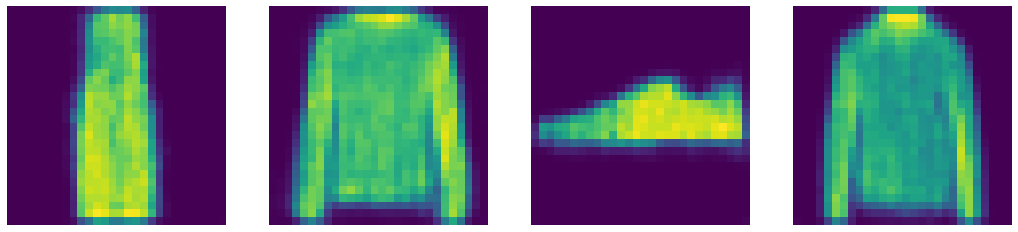

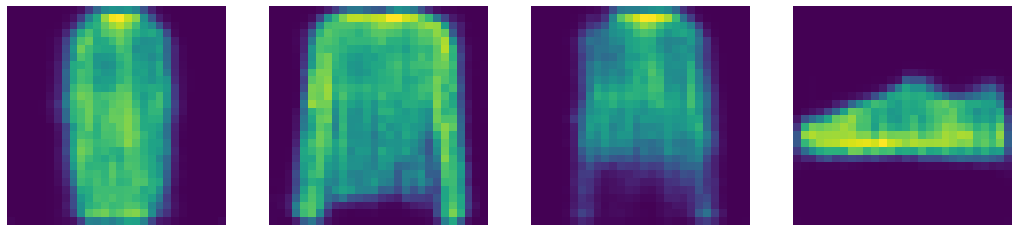

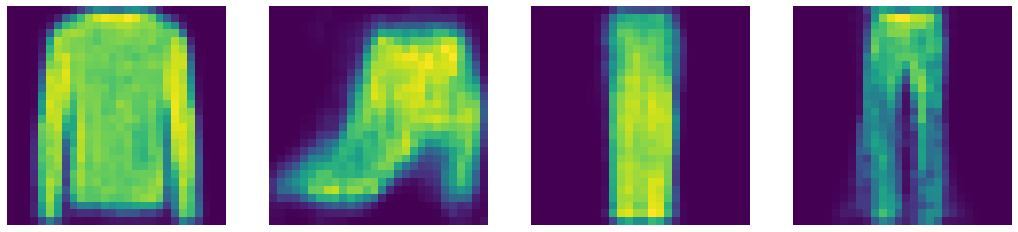

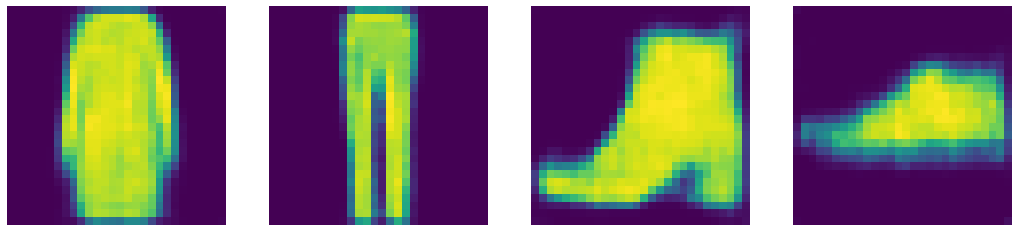

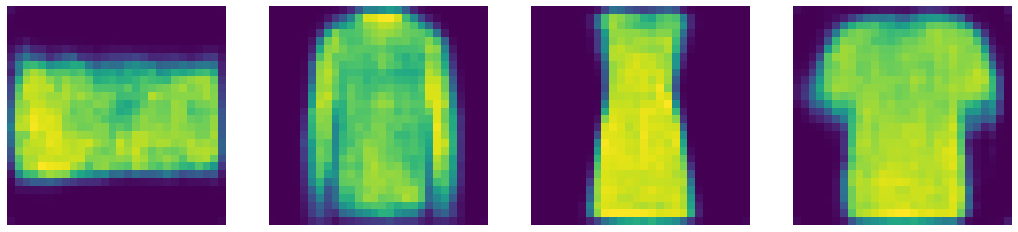

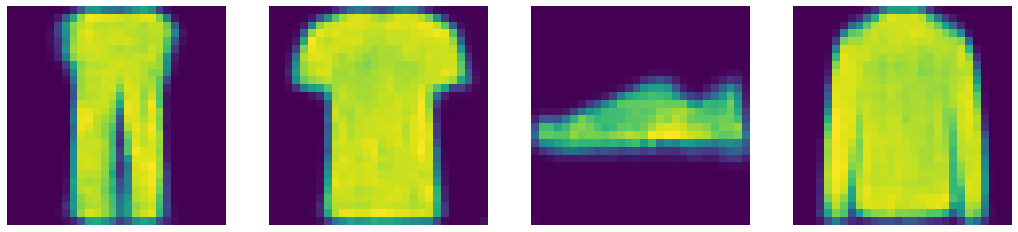

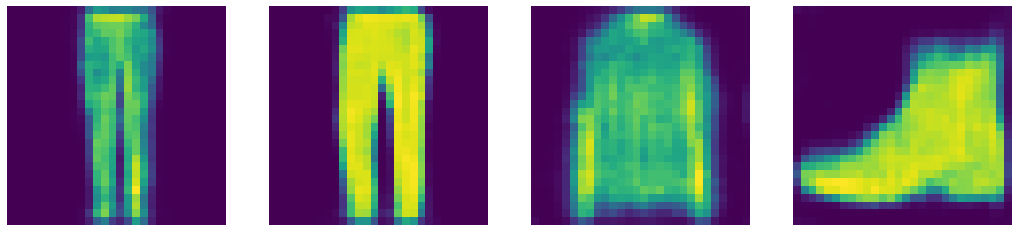

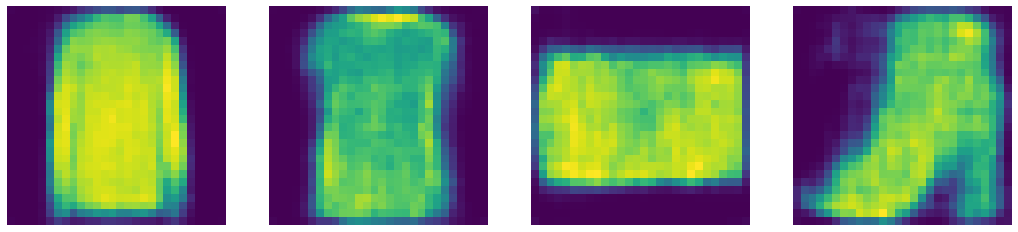

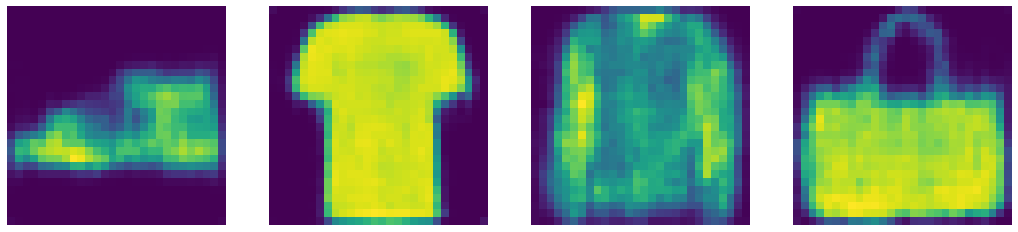

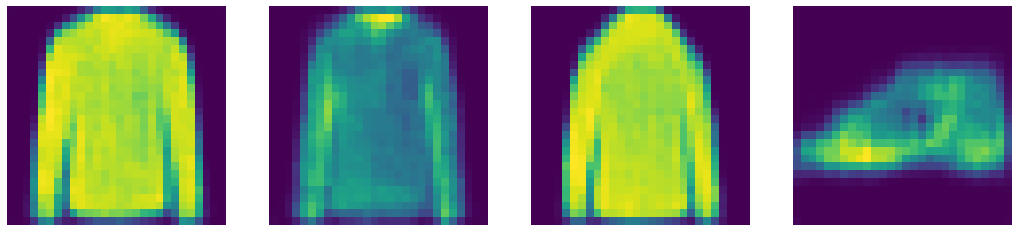

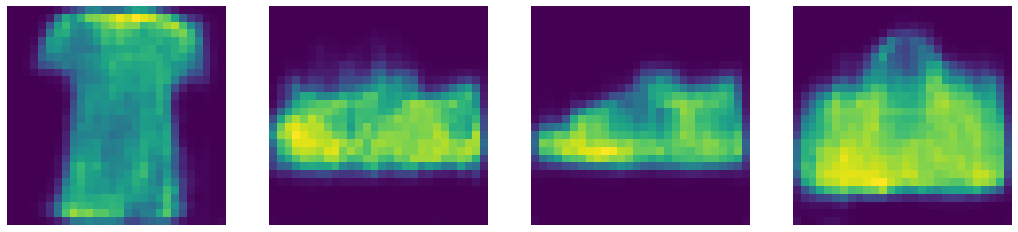

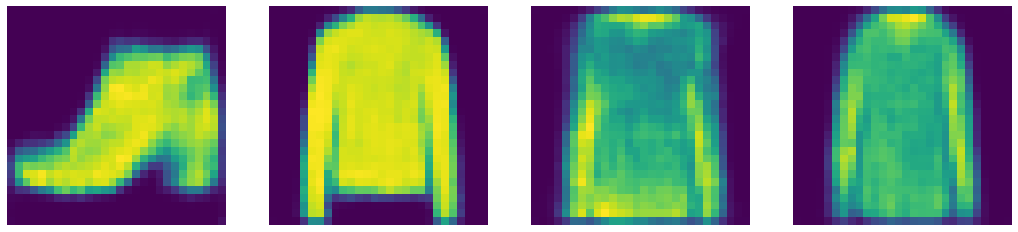

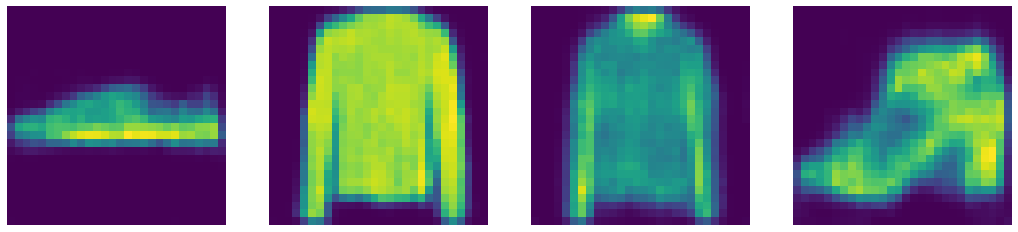

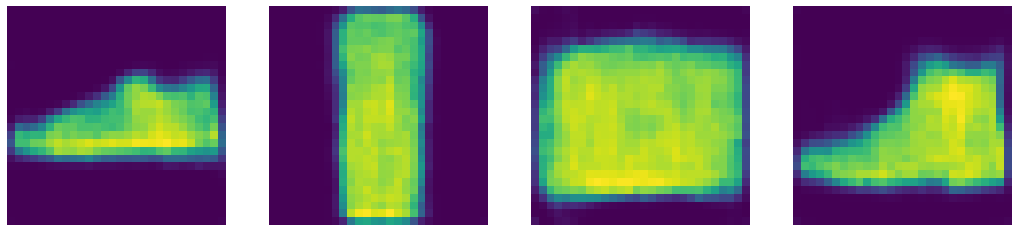

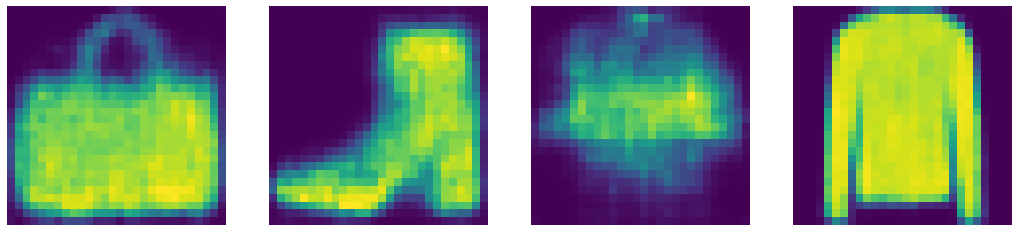

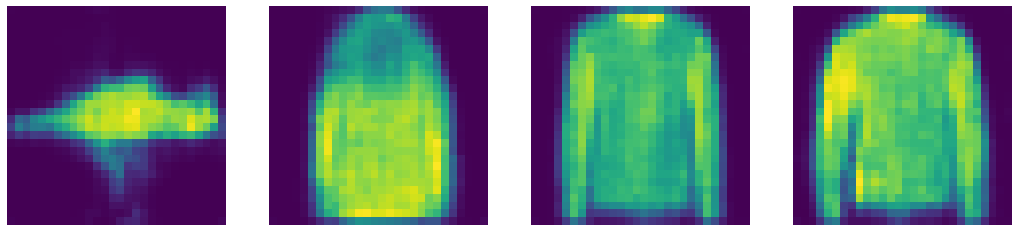

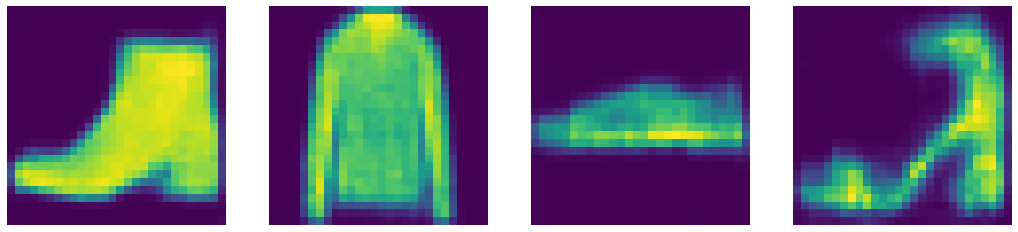

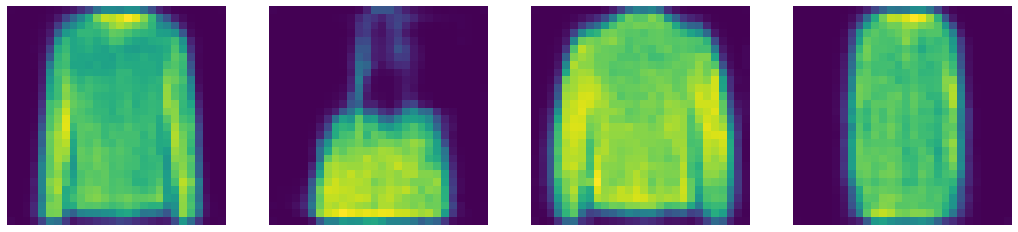

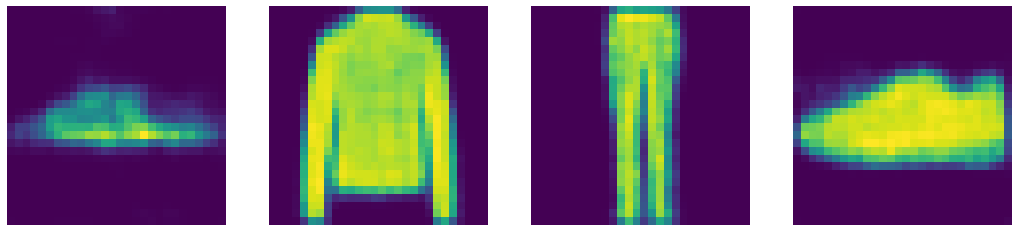

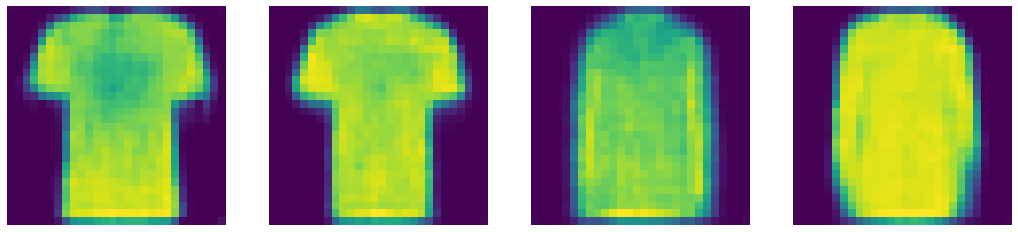

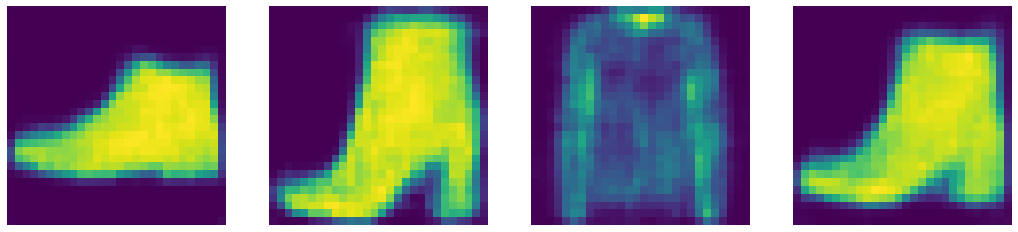

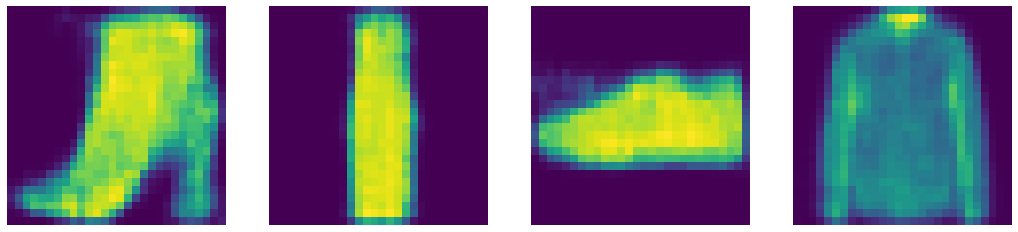

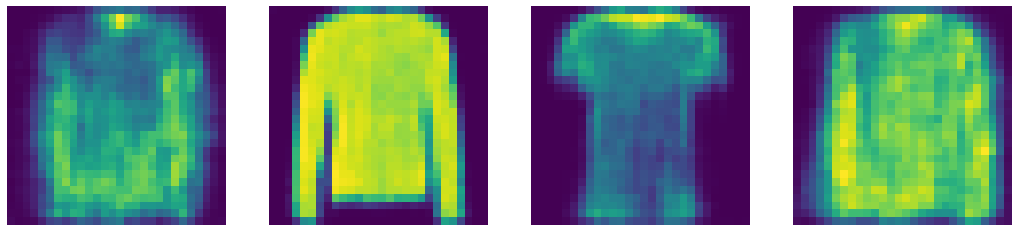

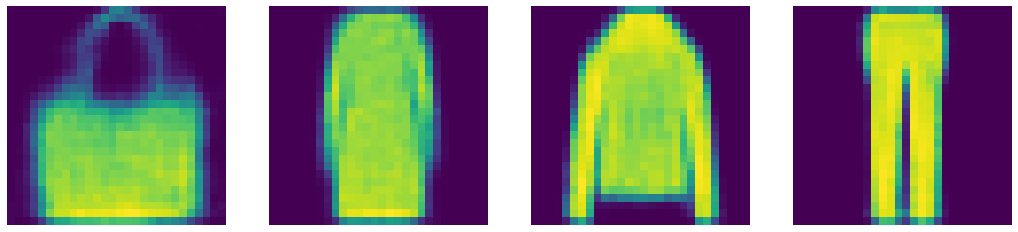

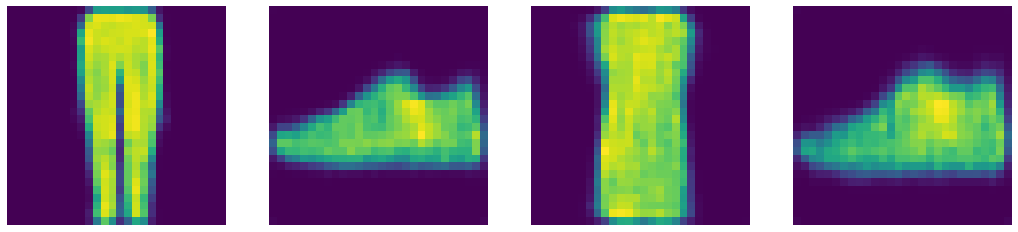

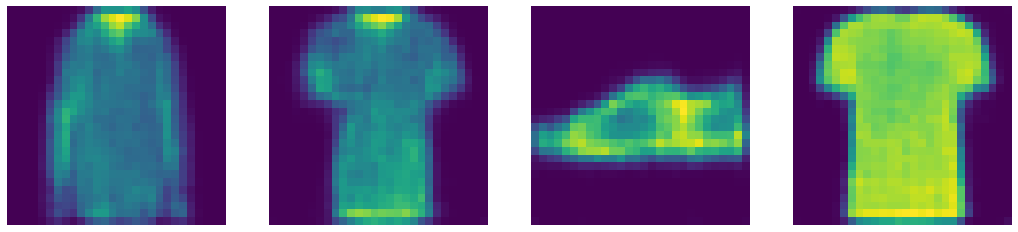

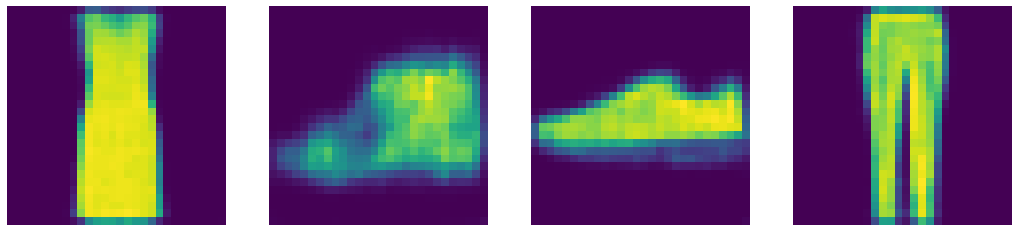

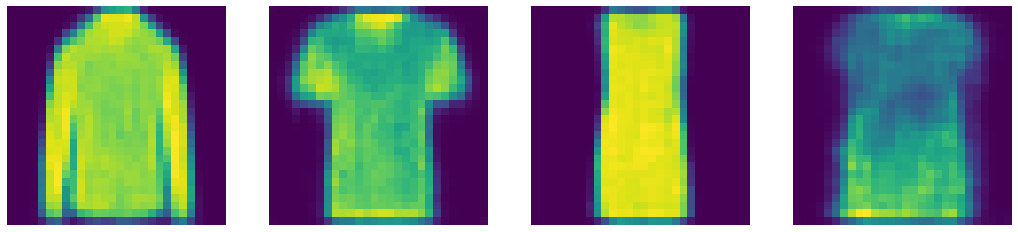

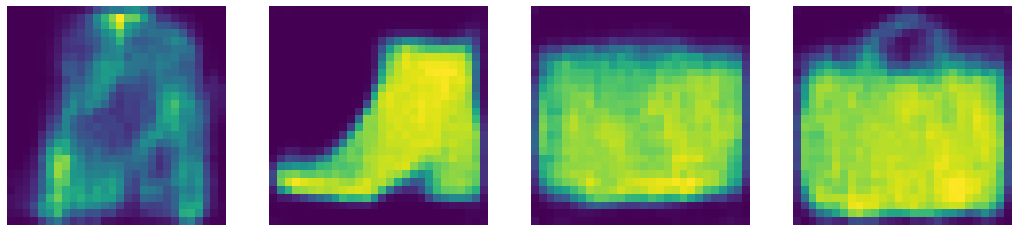

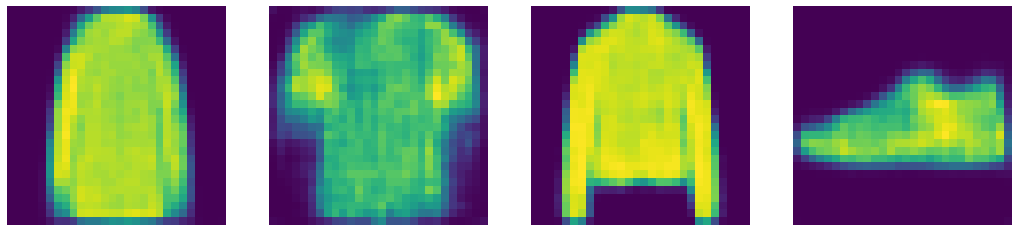

In [178]:
num_epochs = 30
loss_c=[]
beta=2

for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img=img.to(torch.device('cuda'))

        img.requires_grad_()
        #img = img.view(img.size(0), -1)
        output,mu,var = model(img)  
        loss = loss_function(output,img.data,mu,var,beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    loss_c.append(loss)
    display_images(None, output)

In [0]:
from torch.autograd import Variable
plt.style.use('default')
%matplotlib inline 

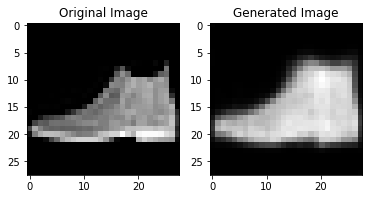

In [180]:
model=model.cpu()
test_images, labels = next(iter(testloader))
test_images = Variable(test_images)
test_output,_,_ = model(test_images)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

fig = plt.figure()
plot = fig.add_subplot(1, 2, 1)
plot.set_title('Original Image')
imgplot = plt.imshow(inp[0].cpu(), cmap='gray')

plot = fig.add_subplot(1, 2, 2)
plot.set_title('Generated Image')
imgplot = plt.imshow(out[0].cpu().detach(), cmap='gray')
plt.show()

# Exercise3

Compare to the fully connected auto-encoder, the CNN gives a better performance with a loss of  0.0008 agains 0.0172 for the fully connected auto-encode. 

Text(0.5, 1.0, 'fully connected auto-encoder')

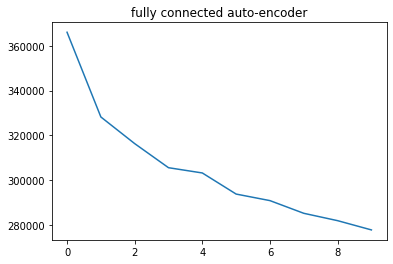

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
#Loss for the fully connected auto-encoder
plt.plot(loss_c)
plt.title("fully connected auto-encoder")


Text(0.5, 1.0, 'CNN auto-encoder')

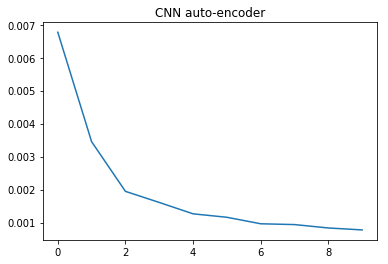

In [0]:
#Loss for the CNN auto-encoder

plt.plot(loss_c)
plt.title("CNN auto-encoder")